In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from tqdm import tqdm

import matplotlib.pyplot as plt

In [28]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 784
HIDDEN_DIM = 256
LATENT_DIM = 32
EPOCHS = 50
BATCH_SIZE = 32
LR_RATE = 3e-4
BETA = 0.96

In [3]:
data = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=data, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.64MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.69MB/s]


In [ ]:
class CVAE(nn.Module):
    def __init__(self, latent_dim: int = 32, cond_dim: int = 10):
        super(CVAE, self).__init__()

        self.latent_dim = latent_dim
        self.cond_dim = cond_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.fc_mu = nn.Linear(128 + cond_dim, latent_dim)
        self.fc_log_var = nn.Linear(128 + cond_dim, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim + cond_dim, 128)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
        )

    def encode(self, x, y_cond):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        h = torch.cat([h, y_cond], dim=1)
        mu, log_var = self.fc_mu(h), self.fc_log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y_cond):
        z = torch.cat([z, y_cond], dim=1) 
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 128, 1, 1)
        return torch.sigmoid(self.decoder(h))

    def forward(self, x, y_cond):
        if x.dim() == 2:
            x = x.view(-1, 1, 28, 28)

        mu, log_var = self.encode(x, y_cond)
        z = self.reparameterize(mu, log_var)
        reconstructed_x = self.decode(z, y_cond)
        return reconstructed_x, mu, log_var


def cvae_loss(recon_x, x, mu, log_var, beta: float = 1.0):
    if x.dim() == 2:
        x = x.view(-1, 1, 28, 28)

    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + beta * KLD


In [ ]:
def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes).float()

cvae = CVAE().to(DEVICE)
optimizer = torch.optim.Adam(cvae.parameters(), lr=LR_RATE)

cvae.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    for i, (x, y) in tqdm(enumerate(train_loader), colour='green', desc=f'Epoch [{epoch+1}/{EPOCHS}]', unit='batch'):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        y_cond = one_hot(y, num_classes=10).to(DEVICE)

        optimizer.zero_grad()
        recon_x, mu, log_var = cvae(x, y_cond)

        loss = cvae_loss(recon_x, x, mu, log_var, beta=1.0)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Loss: {epoch_loss / len(train_loader.dataset):.4f}")

Epoch [1/50]: 1875batch [00:16, 114.30batch/s]


Loss: 145.6915


Epoch [2/50]: 1875batch [00:15, 121.70batch/s]


Loss: 110.8448


Epoch [3/50]: 1875batch [00:16, 115.99batch/s]


Loss: 107.8036


Epoch [4/50]: 1875batch [00:16, 117.15batch/s]


Loss: 105.9496


Epoch [5/50]: 1875batch [00:15, 120.23batch/s]


Loss: 104.9138


Epoch [6/50]: 1875batch [00:15, 120.77batch/s]


Loss: 104.0448


Epoch [7/50]: 1875batch [00:15, 119.32batch/s]


Loss: 103.3728


Epoch [8/50]: 1875batch [00:15, 120.30batch/s]


Loss: 102.7830


Epoch [9/50]: 1875batch [00:15, 121.19batch/s]


Loss: 102.2974


Epoch [10/50]: 1875batch [00:15, 122.02batch/s]


Loss: 101.9868


Epoch [11/50]: 1875batch [00:15, 117.60batch/s]


Loss: 101.6109


Epoch [12/50]: 1875batch [00:15, 120.01batch/s]


Loss: 101.2301


Epoch [13/50]: 1875batch [00:15, 121.32batch/s]


Loss: 101.0050


Epoch [14/50]: 1875batch [00:15, 117.90batch/s]


Loss: 100.7025


Epoch [15/50]: 1875batch [00:15, 121.22batch/s]


Loss: 100.4323


Epoch [16/50]: 1875batch [00:15, 120.73batch/s]


Loss: 100.2563


Epoch [17/50]: 1875batch [00:15, 117.65batch/s]


Loss: 100.0420


Epoch [18/50]: 1875batch [00:15, 120.00batch/s]


Loss: 99.9087


Epoch [19/50]: 1875batch [00:15, 120.97batch/s]


Loss: 99.6693


Epoch [20/50]: 1875batch [00:15, 119.15batch/s]


Loss: 99.5490


Epoch [21/50]: 1875batch [00:15, 118.70batch/s]


Loss: 99.4435


Epoch [22/50]: 1875batch [00:15, 121.19batch/s]


Loss: 99.2479


Epoch [23/50]: 1875batch [00:15, 121.60batch/s]


Loss: 99.1147


Epoch [24/50]: 1875batch [00:16, 110.87batch/s]


Loss: 98.9254


Epoch [25/50]: 1875batch [00:18, 103.46batch/s]


Loss: 98.8641


Epoch [26/50]: 1875batch [00:16, 114.12batch/s]


Loss: 98.6679


Epoch [27/50]: 1875batch [00:15, 121.15batch/s]


Loss: 98.5864


Epoch [28/50]: 1875batch [00:15, 120.91batch/s]


Loss: 98.4364


Epoch [29/50]: 1875batch [00:15, 119.98batch/s]


Loss: 98.4062


Epoch [30/50]: 1875batch [00:15, 119.62batch/s]


Loss: 98.2413


Epoch [31/50]: 1875batch [00:15, 120.64batch/s]


Loss: 98.1257


Epoch [32/50]: 1875batch [00:16, 114.80batch/s]


Loss: 98.0184


Epoch [33/50]: 1875batch [00:15, 119.07batch/s]


Loss: 97.8460


Epoch [34/50]: 1875batch [00:15, 120.31batch/s]


Loss: 97.8411


Epoch [35/50]: 1875batch [00:15, 120.57batch/s]


Loss: 97.7645


Epoch [36/50]: 1875batch [00:16, 116.28batch/s]


Loss: 97.6768


Epoch [37/50]: 1875batch [00:15, 120.59batch/s]


Loss: 97.5787


Epoch [38/50]: 1875batch [00:15, 120.61batch/s]


Loss: 97.4706


Epoch [39/50]: 1875batch [00:15, 117.41batch/s]


Loss: 97.3493


Epoch [40/50]: 1875batch [00:15, 121.00batch/s]


Loss: 97.3370


Epoch [41/50]: 1875batch [00:15, 121.20batch/s]


Loss: 97.2173


Epoch [42/50]: 1875batch [00:16, 116.25batch/s]


Loss: 97.1275


Epoch [43/50]: 1875batch [00:15, 120.46batch/s]


Loss: 97.0657


Epoch [44/50]: 1875batch [00:15, 119.58batch/s]


Loss: 97.0508


Epoch [45/50]: 1875batch [00:15, 118.17batch/s]


Loss: 96.9608


Epoch [46/50]: 1875batch [00:15, 117.22batch/s]


Loss: 96.9233


Epoch [47/50]: 1875batch [00:15, 120.60batch/s]


Loss: 96.8852


Epoch [48/50]: 1875batch [00:15, 121.07batch/s]


Loss: 96.7222


Epoch [49/50]: 1875batch [00:16, 116.81batch/s]


Loss: 96.6749


Epoch [50/50]: 1875batch [00:15, 120.93batch/s]

Loss: 96.6031


In [30]:
def sample_and_visualize(model, digit, num_samples=8, latent_dim=32, num_classes=10):

    model.eval()
    device = next(model.parameters()).device

    # Create latent vectors ~ N(0,1)
    z = torch.randn(num_samples, latent_dim).to(device)

    # Create condition vector (one-hot of chosen digit)
    y_cond = torch.full((num_samples,), digit, dtype=torch.long).to(device)
    y_cond = F.one_hot(y_cond, num_classes=num_classes).float().to(device)

    # Decode
    with torch.no_grad():
        samples = model.decode(z, y_cond).cpu()

    # Plot
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 2))
    for i in range(num_samples):
        axes[i].imshow(samples[i, 0].numpy(), cmap="gray")
        axes[i].axis("off")
    plt.suptitle(f"Generated samples of digit {digit}")
    plt.show()


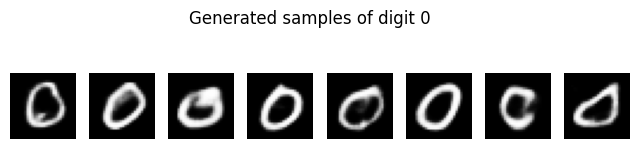

In [32]:
sample_and_visualize(cvae, digit=0, num_samples=8)

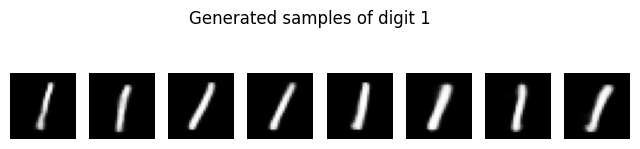

In [33]:
sample_and_visualize(cvae, digit=1, num_samples=8)

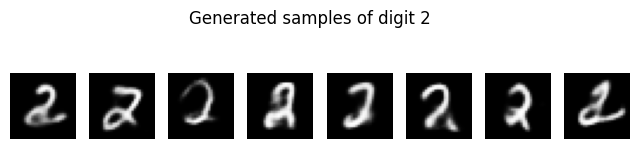

In [34]:
sample_and_visualize(cvae, digit=2, num_samples=8)

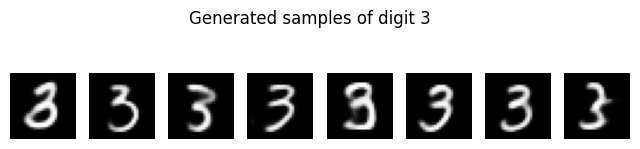

In [35]:
sample_and_visualize(cvae, digit=3, num_samples=8)

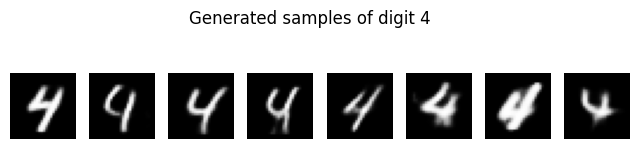

In [37]:
sample_and_visualize(cvae, digit=4, num_samples=8)

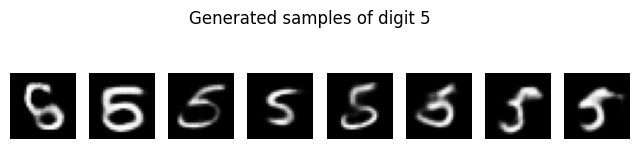

In [38]:
sample_and_visualize(cvae, digit=5, num_samples=8)

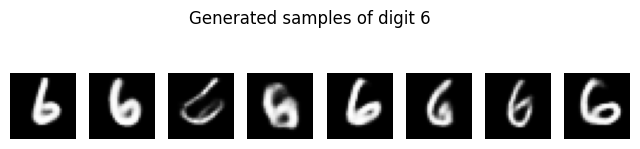

In [39]:
sample_and_visualize(cvae, digit=6, num_samples=8)

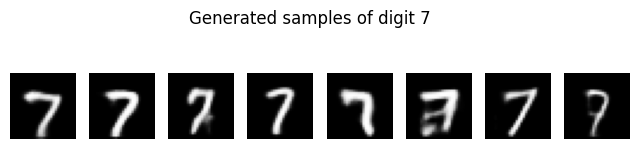

In [36]:
sample_and_visualize(cvae, digit=7, num_samples=8)

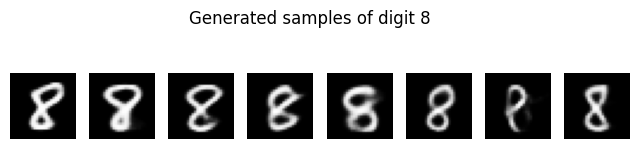

In [40]:
sample_and_visualize(cvae, digit=8, num_samples=8)

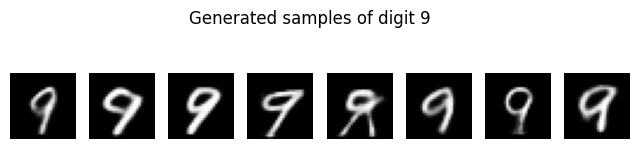

In [41]:
sample_and_visualize(cvae, digit=9, num_samples=8)